# 布谷鸟算法求解基站分配问题  
要求：每个基站的有效范围为10Km，欲让基站信号覆盖所有小区，求解最小的基站数目以及其位置。

In [136]:
from math import radians, cos, sin, asin, sqrt
import numpy as np
import scipy.special as sc_special
import warnings
warnings.filterwarnings('ignore')

### 把经纬度换成km存入数组

In [137]:
import pandas as pd
import matplotlib.pyplot as plt

In [138]:
# 取出数据
df_lnla = pd.read_excel('深圳市楼盘带经纬度.xls')
df_lnla.head()
build_num = len(df_lnla['小区'])

In [139]:
# 转换成km
df_km = df_lnla.copy()
df_km['经度'] *= 111.1
df_km['纬度'] *= 92
df_km.columns = ['小区','x','y']
df_km.head()

,小区,x,y
0,百旺信高管公寓,2500.914217,10481.138640
1,百旺信管理综合楼,2514.165892,10482.324336
2,保利城大厦,2514.250661,10482.351108
3,碧海天,2501.372171,10481.813184
4,碧海云天,2501.260960,10481.566716


array([[ 2502.9938978, 10479.766552 ],
       [ 2506.5158789, 10486.577128 ],
       [ 2502.6578203, 10481.420252 ],
       [ 2505.1742353, 10481.052804 ],
       [ 2508.6098917, 10483.888244 ]])

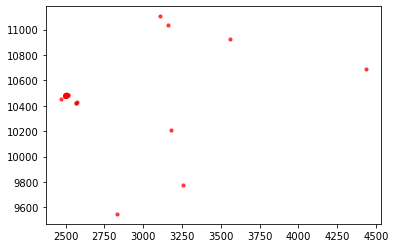

In [149]:
# 画出来吧
x = np.array(df_km['x'])
y = np.array(df_km['y'])
assert(len(x) == len(y))
plt.scatter(x,y,s=10,c='r',alpha=0.7)

# 生成一个元素存放一个点的数组
x = [[i] for i in x]
y = [[i] for i in y]
buildings = np.concatenate((x, y), axis=1)
buildings[-5:]

### 找出相互距离在20km之内的节点组合

In [141]:
import scipy.spatial

In [142]:
# 计算各小区间的的距离
build2build = scipy.spatial.distance.cdist(buildings,buildings,metric='euclidean') # 欧式距离算各点间的距离
# 输出到excel中
df_build2build = pd.DataFrame(build2build)
df_build2build.columns = df_km['小区']
df_build2build.index = df_km['小区']
df_build2build.to_csv('小区与小区间的距离.csv', encoding="utf_8_sig")
df_build2build.head()

小区,百旺信高管公寓,百旺信管理综合楼,保利城大厦,碧海天,碧海云天,滨福世纪广场,滨福庭园,滨海之窗,缤纷假日花园,缤纷年华,...,园景园,跃华园,粤海工业村5－6栋,云海天城,云栖西岸阁,中爱花园,中润百分百公寓,中山颐景,众冠西郡园,碧海蓝天
小区,,,,,,,,,,,,,,,,,,,,,
百旺信高管公寓,0.000000,13.304614,13.391446,0.815311,0.550890,6.746112,2.735301,2.750395,1.445571,1.124848,...,3.235710,1.897733,1.718830,0.261405,0.674157,2.491525,7.807418,1.766199,4.260883,8.172131
百旺信管理综合楼,13.304614,0.000000,0.088896,12.803928,12.927152,11.705334,11.684931,11.538477,12.146940,12.186946,...,10.171594,15.133508,11.607121,13.491141,12.963253,11.461052,8.752653,11.543529,9.081116,5.771910
保利城大厦,13.391446,0.088896,0.000000,12.889719,13.013362,11.770650,11.767077,11.620846,12.232282,12.273586,...,10.259538,15.219605,11.694347,13.578224,13.049161,11.549660,8.813972,11.630152,9.168811,5.846457
碧海天,0.815311,12.803928,12.889719,0.000000,0.270397,5.947324,1.920649,1.940168,0.697596,0.788756,...,2.960785,2.337270,1.477119,1.075686,0.172026,2.611264,7.010912,1.344355,3.877353,7.529308
碧海云天,0.550890,12.927152,13.013362,0.270397,0.000000,6.217488,2.185297,2.199535,0.910879,0.784197,...,2.985009,2.207509,1.467371,0.812267,0.180643,2.498732,7.260744,1.404518,3.946876,7.706899


In [143]:
# 找出各小区与其距离20km内的小区
close_ind = np.argwhere((build2build <=20) & (build2build != 0))
close_dict = {i:set([]) for i in range(build_num)}   # 以字典形式存起来
for _ in close_ind:
    close_dict[_[0]].add(_[1])

### 建立基站  
- 小区有0个20km内的小区，则基站定于小区位置附近的随机坐标
- 小区有1个20km内的小区，则基站定于两者之间
- 小区有2个及以上20km内的小区，进行布谷鸟迭代选址

#### 处理有0、1邻居的小区

In [144]:
s = {0:[], 1:[], 2:[]}  # 存放已建立基站的km坐标
close_temp = close_dict
cover = set([]) # 信号已覆盖的小区
# proceing = set([])  #正在处理的多邻居小区
# neig_cluster = []   #   存放多小区的邻居与邻居的邻居

"""对0、1邻居小区的建基站,多小区的进行聚集合并"""
for k in list(close_temp.keys()):
    v = close_temp[k]

    # 处理0个小区的
    if len(v) == 0:
        #  print(k) 
        #   附近生成随机基站
        x_s = df_km.iloc[k, 1]+np.random.randint(-10, high=10,size=1)
        y_s = df_km.iloc[k, 2]+np.random.randint(-10, high=10,size=1)
        s[0].append([x_s/111.1,y_s/92])
        cover.add(k)
        del close_temp[k]

    #   处理1个小区的
    elif len(v) == 1:
        if k not in cover:
            x1, y1 = df_km.iloc[k, 1], df_km.iloc[k, 2]
            x2, y2 = df_km.iloc[v, 1], df_km.iloc[v, 2]
            s[1].append([(x1 + x2) / 2, (y1 + y2) / 2])
            cover.update(k, v)
        else:pass
        del close_temp[k]

    #   聚集多小区的邻居与邻居的邻居
    else:
        # if k not in cover:
        #     temp = close_temp[k].add(k)
        #     for i in close_temp[k]:
        #         temp.update(close_temp[i],{i})
        #     temp
        pass
cover
print(s[0])
print(s[1])


[[array([25.5757961]), array([103.797931])], [array([29.2181587]), array([106.2355073])], [array([28.6493853]), array([110.89975961])], [array([28.3944186]), array([120.00211539])], [array([27.9818761]), array([120.68852543])], [array([39.9334807]), array([116.1861963])], [array([32.1045063]), array([118.72283761])], [array([22.2276022]), array([113.52468961])]]
[]


#### 处理有多个邻居的小区

In [145]:
#   将多个小区新建表单存储
multi_neig = close_temp.keys()
lng_a, lat_a = df_km.iloc[list(multi_neig),1], df_km.iloc[list(multi_neig),2]
df_multi_neig = pd.DataFrame(index=multi_neig)
df_multi_neig['x'] = lng_a
df_multi_neig['y'] = lat_a
df_multi_neig.to_csv('多个邻居的小区位置.csv', encoding="utf_8_sig")
df_multi_neig.tail()

,x,y
198,2502.993898,10479.766552
199,2506.515879,10486.577128
200,2502.657820,10481.420252
201,2505.174235,10481.052804
202,2508.609892,10483.888244


In [146]:
# 生成一个元素存放一个小区位置的数组
x = df_multi_neig['x']
y = df_multi_neig['y']
x = [[i] for i in df_multi_neig['x']]
y = [[i] for i in df_multi_neig['y']]
x_boundary = [min(x), max(x)]
y_boundary = [min(y), max(y)]
multi_neig_point = np.concatenate((np.array(x), np.array(y)), axis=1)
multi_neig_point[:5]

array([[ 2500.9142169, 10481.13864  ],
       [ 2514.1658916, 10482.324336 ],
       [ 2514.2506609, 10482.351108 ],
       [ 2501.3721711, 10481.813184 ],
       [ 2501.26096  , 10481.566716 ]])

In [147]:
class cuckoo:
    def __init__(self, n, m, buildings, x_boundary, y_boundary, iter_num = 70, pa = 0.25, step = 2):
        """
        Input============
        n:鸟数
        m:下了的槽数
        x_boundary-> 1*2 array (min,max)
        pa: 丢弃概率
        step: 更新的移动距离
        """
        self.n = n  # 鸟的数目
        self.m = int(m)  # 基站个数
        self.pa = pa
        self.step = step
        self.iter_num = iter_num
        self.buildings = buildings  # 小区位置
        self.station = {}
        self.x_boundary = np.tile(x_boundary, (self.m,1)).reshape(self.m, 2)
        self.y_boundary = np.tile(y_boundary, (self.m,1)).reshape(self.m, 2)
        self.x_nests = np.empty((n, self.m))
        self.y_nests = np.empty((n, self.m))
        self.fitness = np.empty((1, n))    #   np.zeros((1, n))+100
        self.best_fit = 100
        self.best_station_x = np.zeros(1*self.m)
        self.best_station_y = np.zeros(1*self.m)

    def generate_nests(self):
        """
        Generate the nests' locations
        ---------------------------------------------------
        Output:
            generated nests' locations
        """
        for each_nest in range(self.n):
            x_s = self.x_boundary[:,0] + np.array([np.random.rand() for _ in range(self.m)]) * (self.x_boundary[:,1]-self.x_boundary[:,0])
            y_s = self.y_boundary[:,0] + np.array([np.random.rand() for _ in range(self.m)]) * (self.y_boundary[:,1]-self.y_boundary[:,0])
            
            self.x_nests[each_nest] = x_s.copy() # 写入一行基站的x坐标
            self.y_nests[each_nest] = y_s.copy()
        return self.x_nests,self.y_nests
    
    def calc_fitness(self, x_nests, y_nests):
        """
        计算适应度,即没有被一组基站的信号cover住的小区
        如果一个小区对于最近的基站距离大于10km,则适应度+1
        ---------------------------------------------------
        Input parameters:
            nests:  Nests' locations n*m array
        Output:
            Every nest's fitness
        """
        fitness = self.fitness.copy()
        for each_nest in range(self.n):
            # 把x,y组合成列表
            x = [[i] for i in x_nests[each_nest,:]]
            y = [[i] for i in y_nests[each_nest,:]]
            nest = np.concatenate((x, y), axis=1)
            # print(nest[:5])

            # 计算距离
            station2build = scipy.spatial.distance.cdist(nest,multi_neig_point,metric='euclidean')
            min_dis = station2build.min(0)    # 返回每列最小值
            fitness[0,each_nest] = min_dis[min_dis>10].size
            # TODO 为什么首次fitness就会有0值？
        # self.save_best(fitness)
        return fitness
        
    def save_best(self,fitness):
        if fitness.min() < self.best_fit:
            best_index = np.argmin(fitness)
            self.best_station_x = self.x_nests[best_index,:].copy()
            self.best_station_y = self.y_nests[best_index,:].copy()
            self.best_fit = fitness.min()

    def update_nests(self, step_coefficient=0.5):
        """
        This function is to get new nests' locations and use new better one to replace the old nest
        ---------------------------------------------------
        Input parameters:
            step_coefficient:  Step size scaling factor related to the problem's scale (default: 0.5)
        更新:self.x/y_nests
        """
        # generate steps using levy flight
        steps = self.levy_flight()
        x_nests = self.x_nests.copy()
        y_nests = self.y_nests.copy()

        for each_nest in range(self.n):
            # coefficient 0.01 is to avoid levy flights becoming too aggresive
            # and (nest[each_nest] - best_nest) could let the best nest be remained
            step_size_x = step_coefficient * steps[each_nest] * (x_nests[each_nest] - self.best_station_x)
            step_size_y = step_coefficient * steps[each_nest] * (y_nests[each_nest] - self.best_station_y)
            step_direction = np.random.rand(self.m)
            x_nests[each_nest] += step_size_x * step_direction
            y_nests[each_nest] += step_size_y * step_direction

            # apply boundary condtions
            x_nests[each_nest][x_nests[each_nest] < self.x_boundary[0,0]] = self.x_boundary[0,0]
            x_nests[each_nest][x_nests[each_nest] > self.x_boundary[0,1]] = self.x_boundary[0,1]
            y_nests[each_nest][y_nests[each_nest] < self.y_boundary[0,0]] = self.y_boundary[0,0]
            y_nests[each_nest][y_nests[each_nest] > self.y_boundary[0,1]] = self.y_boundary[0,1]

        temp_fitness = self.fitness.copy()
        new_fitness = self.calc_fitness(x_nests, y_nests)
        self.x_nests[list(new_fitness > temp_fitness)][:] = x_nests[list(new_fitness > temp_fitness)]
        self.y_nests[list(new_fitness > temp_fitness)] = y_nests[list(new_fitness > temp_fitness)]
        self.save_best(self.calc_fitness(self.x_nests, self.y_nests))
        
    def levy_flight(self, beta = 0.5):
        """
        This function implements Levy's flight.
        ---------------------------------------------------
        Input parameters:
            n: Number of steps 
            m: Number of dimensions
            beta: Power law index (note: 1 < beta < 2)
        Output:
            'n' levy steps in 'm' dimension
        """
        sigma_u = (sc_special.gamma(1+beta)*np.sin(np.pi*beta/2)/(sc_special.gamma((1+beta)/2)*beta*(2**((beta-1)/2))))**(1/beta)
        sigma_v = 1

        u =  np.random.normal(0, sigma_u, (self.n, self.m))
        v = np.random.normal(0, sigma_v, (self.n, self.m))

        steps = u/((np.abs(v))**(1/beta))
        return steps

    def abandon_nests(self):
        """
        Some cuckoos' eggs are found by hosts, and are abandoned.So cuckoos need to find new nests.
        ---------------------------------------------------
        Input parameters:
            nests: Current nests' locations
            lower_boundary: Lower bounary (example: lower_boundary = (-2, -2, -2))
            upper_boundary: Upper boundary (example: upper_boundary = (2, 2, 2))
            pa: Possibility that hosts find cuckoos' eggs
        更新: self.x/y_nests
        """
        x_nests = self.x_nests
        y_nests = self.y_nests
        for each_nest in range(self.n):
            if (np.random.rand() < self.pa):
                # 丢弃x、y现在的位置,移动到新的地区
                x_step_size = np.random.rand() * (x_nests[np.random.randint(0, self.n)] - x_nests[np.random.randint(0, self.n)])
                y_step_size = np.random.rand() * (y_nests[np.random.randint(0, self.n)] - y_nests[np.random.randint(0, self.n)])
                x_nests[each_nest] += x_step_size
                y_nests[each_nest] += y_step_size

                # apply boundary condtions
                x_nests[each_nest][list(x_nests[each_nest] < self.x_boundary[0,0])] = self.x_boundary[0,0]
                x_nests[each_nest][list(x_nests[each_nest] > self.x_boundary[0,1])] = self.x_boundary[0,1]
                y_nests[each_nest][list(y_nests[each_nest] < self.y_boundary[0,0])] = self.y_boundary[0,0]
                y_nests[each_nest][list(y_nests[each_nest] > self.y_boundary[0,1])] = self.y_boundary[0,1]
        self.calc_fitness(x_nests, y_nests)
    
    def run(self):
        self.generate_nests()
        self.fitness = self.calc_fitness(self.x_nests,self.y_nests)
        for _ in range(self.iter_num):
            self.update_nests()
            self.abandon_nests()
            self.fitness = self.calc_fitness(self.x_nests,self.y_nests)
            self.save_best(self.fitness)
            print(self.best_fit,end='\t')

    def draw(self, station_x, station_y):
        """
        In: 一组基站的x,y
        Out: 画基站与小区
        """
        plt.scatter(self.buildings[:,0], self.buildings[:,1], s =10, c = 'b', alpha=0.6)
        plt.scatter(station_x, station_y, s = 3500, c = 'orange', alpha = 0.2)
        # plt.scatter(2500,10430,s=2600,c='red',alpha=0.5)
        # for _ in range(self.m):
        #     pint(10, self.best_station_x[_], self.best_station_y[_], ax=ax)
        plt.show()
        plt.savefig('多邻居的%d基站.jpg'%self.m)

    def pint(r,x,y,ax):
        plt.xlabel('x')
        plt.ylabel('y')
        # 点的横坐标为a
        a = np.arange(x-r,x+r,0.000001)
        # 点的纵坐标为b
        b = np.sqrt(np.power(r,2)-np.power((a-x),2))+y
        ax.plot(a,b,color='r',linestyle='-')
        ax.plot(a,-b,color='r',linestyle='-')
        ax.scatter(x,y,c='orange',s=10, marker='o')


对多邻居建设10个基站
6.0	6.0	6.0	2.0	2.0	2.0	2.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	

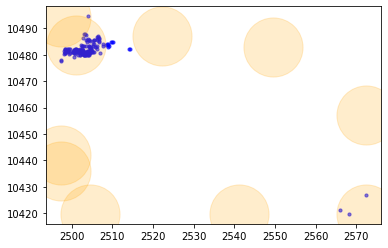


对多邻居建设9个基站
4.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	1.0	1.0	1.0	1.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	

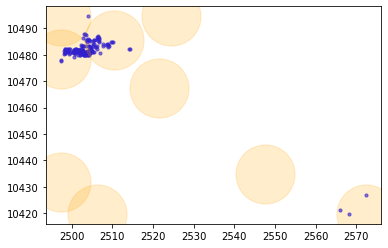


对多邻居建设8个基站
3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	2.0	2.0	2.0	2.0	2.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	

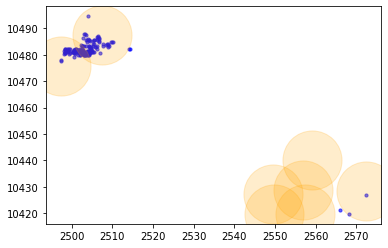


对多邻居建设7个基站
39.0	39.0	6.0	6.0	6.0	6.0	6.0	6.0	4.0	4.0	4.0	4.0	2.0	2.0	2.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	

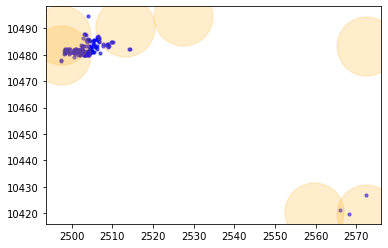


对多邻居建设6个基站
100	35.0	35.0	14.0	14.0	14.0	14.0	14.0	14.0	2.0	2.0	2.0	2.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	

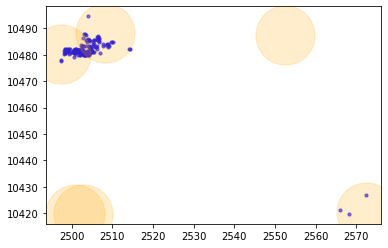


对多邻居建设5个基站
41.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	3.0	3.0	3.0	3.0	3.0	3.0	2.0	2.0	2.0	2.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	

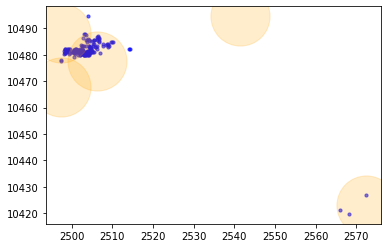


对多邻居建设4个基站
14.0	11.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	2.0	2.0	2.0	2.0	2.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	

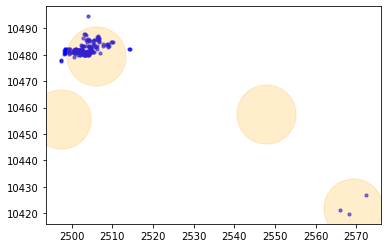


对多邻居建设3个基站
100	7.0	7.0	7.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	5.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	4.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	2.0	2.0	2.0	2.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	

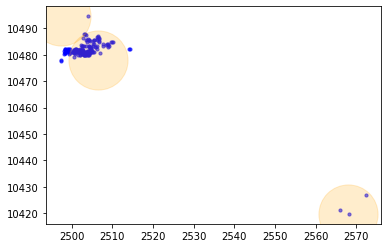


对多邻居建设2个基站
100	100	11.0	11.0	11.0	6.0	6.0	6.0	6.0	6.0	6.0	6.0	6.0	6.0	6.0	6.0	6.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	3.0	

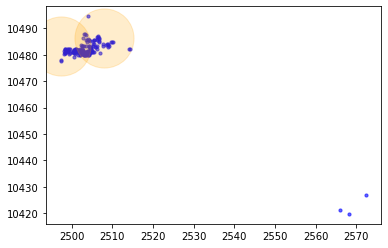

<Figure size 432x288 with 0 Axes>

In [150]:
"""
用布谷鸟算法寻优:
设每代50组数据一并计算, 起始迭代的基站数m为小区/2, 
适应性函数为未被包含的小区数, 适应性函数为0时, 基站数m-1进行新的布谷鸟搜索
所以当前布谷鸟跳出的条件是: 循环次数达到或者适应度函数为0
取到最优的情况是适应度函数不为零,但迭代次数用完
"""

for m in range(10,1,-1):
    print('\n','='*30)
    print("对多邻居建设%d个基站"%m)
    cuckoo_station = cuckoo(50, m = m, buildings=multi_neig_point,iter_num=200, x_boundary=x_boundary, y_boundary=y_boundary, step = 2)
    cuckoo_station.run()
    cuckoo_station.draw(cuckoo_station.best_station_x, cuckoo_station.best_station_y)
    cuckoo_station.best_fit

    # 存储经纬度
    # df_build2build.columns.append('%d_x'%m)
    # df_build2build.columns.append('%d_y'%m)
    # df_multi_station = pd.DataFrame((cuckoo_station.best_station_x/111.1, cuckoo_station.best_station_y/92))
    df_multi_station = pd.DataFrame()
    df_multi_station.insert(loc=len(df_multi_station.columns), column=str('经度%d'%m), value=cuckoo_station.best_station_x/111.1)
    df_multi_station.insert(loc=len(df_multi_station.columns), column=str('纬度%d'%m), value=cuckoo_station.best_station_y/92)
    # df_build2build['x'] = cuckoo_station.best_station_x/111.1
    # df_build2build['y'] = cuckoo_station.best_station_y/92
    df_multi_station.to_csv('多小区%d基站位置.csv'%m, encoding="utf_8_sig")